# 4 Training and Modelling the Data<a id='4_Training_and_Modeling_the_Data'></a>

## 4.1 Contents<a id='4.1_Contents'></a>
* [4 Training and Modelling the Data](#4_Training_and_Modelling_the_Data)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Imports](#4.2_Imports)
  * [4.3 Load Data](#4.3_Load_Data)
  * [4.4 Create Dummy Variables](#4.4_Create_Dummy_Variables)
  * [4.5 Train/Test Split](#4.5_Train_Test_Split)
  * [4.6 Modelling](#4.6_Modelling)
    * [4.6.1 Decision Tree with Entropy](#4.6.1_Decision_Tree_with_Entropy)
        * [4.6.1.1 Train the model on the train split](#4.6.1.1_Train_the_model_on_the_train_split)
        * [4.6.1.2 Make predictions using the model on both train and test splits](#4.6.1.2_Make_predictions_using_the_model_on_both_train_and_test_splits)
        * [4.6.1.3 Assess model performance](#4.6.1.3_Assess_model_performance)
    * [4.6.2 Decision Tree without Entropy](#4.6.2_Decision_Tree_without_entropy)
        * [4.6.2.1 Train the model on the train split](#4.6.2.1_Train_the_model_on_the_train_split)
        * [4.6.2.2 Make predictions using the model on both train and test splits](#4.6.2.2_Make_predictions_using_the_model_on_both_train_and_test_splits)
        * [4.6.2.3 Assess model performance](#4.6.1.3_Assess_model_performance)
  * [4.7 Final Model Selection](#4.7_Final_Model_Selection)
    * [4.7.1 Logistic regression model performance](#4.7.1_Logistic_regression_model_performance)
    * [4.7.2 Decision Tree model performance](#4.7.2_Decision_Tree_model_performance)
    * [4.7.3 Conclusion](#4.7.3_Conclusion)

## 4.2 Imports<a id='4.2_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from sklearn import tree
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
import pydotplus
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
from IPython.display import Image  
import pydotplus


## 4.3 Load Data<a id='4.3_Load_Data'></a>

In [2]:
spotify_data = pd.read_csv('../data/genre_music.csv')
spotify_data.head()

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_s,time_signature,chorus_hit,sections,popularity,decade,genre
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,185.655,173.533,3,32.94975,9,1,60s,edm
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,101.801,213.613,4,48.82510,10,0,60s,pop
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,115.940,223.960,4,37.22663,12,0,60s,pop
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,105.592,157.907,4,24.75484,8,0,60s,pop
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,114.617,245.600,4,21.79874,14,0,60s,r&b


In [3]:
spotify_data.shape

(41099, 20)

## 4.4 Create Dummy Variables<a id='4.4_Create_Dummy_Variables'></a>

To better utilize the sklearn library, any text variables need to be converted to dummy variables.  Since we are not doing anything with artist or track name, the only dummy varaible we need to convert is decade.  Genre could be created as a dummy variable as well but for ease of analysis, we will leave genre as it exists in the source dataset.

In [4]:
decade_dummy=pd.get_dummies(spotify_data["decade"])
decade_dummy.head()

,00s,10s,60s,70s,80s,90s
0,0,0,1,0,0,0
1,0,0,1,0,0,0
2,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,0,1,0,0,0


In [5]:
# Drop column as it is now encoded
spotify_data = spotify_data.drop(['decade'],axis = 1)
# Join the encoded df
spotify_data_dummies = pd.concat([spotify_data,decade_dummy],axis=1)

In [6]:
spotify_data_dummies.head()

,track,artist,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,...,chorus_hit,sections,popularity,genre,00s,10s,60s,70s,80s,90s
0,Jealous Kind Of Fella,Garland Green,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,...,32.94975,9,1,edm,0,0,1,0,0,0
1,Initials B.B.,Serge Gainsbourg,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,...,48.82510,10,0,pop,0,0,1,0,0,0
2,Melody Twist,Lord Melody,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,...,37.22663,12,0,pop,0,0,1,0,0,0
3,Mi Bomba Sonó,Celia Cruz,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,...,24.75484,8,0,pop,0,0,1,0,0,0
4,Uravu Solla,P. Susheela,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,...,21.79874,14,0,r&b,0,0,1,0,0,0


With the dummy varaiables created and added to the original dataset, we will now drop the track and artist columns for ease of modelling.

In [7]:
spotify_data_dummies = spotify_data_dummies.drop(['track','artist'],axis = 1)

In [8]:
spotify_data_dummies.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,chorus_hit,sections,popularity,genre,00s,10s,60s,70s,80s,90s
0,0.417,0.620,3,-7.727,1,0.0403,0.490,0.000000,0.0779,0.845,...,32.94975,9,1,edm,0,0,1,0,0,0
1,0.498,0.505,3,-12.475,1,0.0337,0.018,0.107000,0.1760,0.797,...,48.82510,10,0,pop,0,0,1,0,0,0
2,0.657,0.649,5,-13.392,1,0.0380,0.846,0.000004,0.1190,0.908,...,37.22663,12,0,pop,0,0,1,0,0,0
3,0.590,0.545,7,-12.058,0,0.1040,0.706,0.024600,0.0610,0.967,...,24.75484,8,0,pop,0,0,1,0,0,0
4,0.515,0.765,11,-3.515,0,0.1240,0.857,0.000872,0.2130,0.906,...,21.79874,14,0,r&b,0,0,1,0,0,0


In [9]:
feature_names = list(spotify_data_dummies.columns[1:])
print("features:", feature_names, sep="\n")

features:
['energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_s', 'time_signature', 'chorus_hit', 'sections', 'popularity', 'genre', '00s', '10s', '60s', '70s', '80s', '90s']


In [10]:
class_names = ['edm', 'latin', 'pop', 'r&b', 'rap', 'rock']
print("classes:", class_names, sep="\n")

classes:
['edm', 'latin', 'pop', 'r&b', 'rap', 'rock']


## 4.5 Train/Test Split<a id='4.5_Train_Test_Split'></a>

In order to get a solid read on the validity of our model, we will need to split our data set into a set to train the model and a set to test the performance of the model.  We will use a 70/30 split where we use 70% of our data to train the model and 30% of the data to test the performance.

In [11]:
len(spotify_data_dummies) * .7, len(spotify_data_dummies) * .3

(28769.3, 12329.699999999999)

In [12]:
spotify_data_dummies.columns

Index(['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_s', 'time_signature', 'chorus_hit', 'sections', 'popularity',
       'genre', '00s', '10s', '60s', '70s', '80s', '90s'],
      dtype='object')

In [13]:
features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_s', 'time_signature', 'chorus_hit', 'sections', 'popularity',
       '00s', '10s', '60s', '70s', '80s', '90s']

X = spotify_data_dummies[features]

y = spotify_data_dummies['genre']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=47)

In [15]:
X_train.shape, X_test.shape

((28769, 22), (12330, 22))

In [16]:
y_train.shape, y_test.shape

((28769,), (12330,))

In [17]:
y_train.value_counts()

pop      11548
r&b       7701
rock      4808
latin     1981
rap       1655
edm       1076
Name: genre, dtype: int64

## 4.6 Models<a id='4.6_Models'></a>

### 4.6.1 Decision Tree with Entropy<a id='4.6.1_Decision_Tree_with_Entropy'></a>

During the exploratory data analysis, the data appeared to best suited for a Decision Tree model since there is a wide selection of songs in the data set, we will first run the Decision Tree with Entropy then run another set of Decision Trees without Entropy to see if there is a difference in performance when entropy is introduced into the model.

#### 4.6.1.1 Train the model on the train split<a id='4.6.1.1_Train_the_model_on_the_train_split'></a>

In [18]:
dtree1 = tree.DecisionTreeClassifier(criterion = 'entropy', max_depth = 4)

dtree1 = dtree1.fit(X_train, y_train)

dtree1_train_text = export_text(dtree1)
print(dtree1_train_text)

|--- feature_11 <= 239.97
|   |--- feature_0 <= 0.36
|   |   |--- feature_5 <= 0.22
|   |   |   |--- class: rock
|   |   |--- feature_5 >  0.22
|   |   |   |--- class: rap
|   |--- feature_0 >  0.36
|   |   |--- feature_1 <= 0.85
|   |   |   |--- feature_5 <= 0.22
|   |   |   |   |--- class: pop
|   |   |   |--- feature_5 >  0.22
|   |   |   |   |--- class: rap
|   |   |--- feature_1 >  0.85
|   |   |   |--- feature_10 <= 170.00
|   |   |   |   |--- class: latin
|   |   |   |--- feature_10 >  170.00
|   |   |   |   |--- class: edm
|--- feature_11 >  239.97
|   |--- feature_0 <= 0.36
|   |   |--- feature_5 <= 0.22
|   |   |   |--- class: rock
|   |   |--- feature_5 >  0.22
|   |   |   |--- class: rap
|   |--- feature_0 >  0.36
|   |   |--- feature_5 <= 0.22
|   |   |   |--- feature_10 <= 170.00
|   |   |   |   |--- class: r&b
|   |   |   |--- feature_10 >  170.00
|   |   |   |   |--- class: edm
|   |   |--- feature_5 >  0.22
|   |   |   |--- class: rap



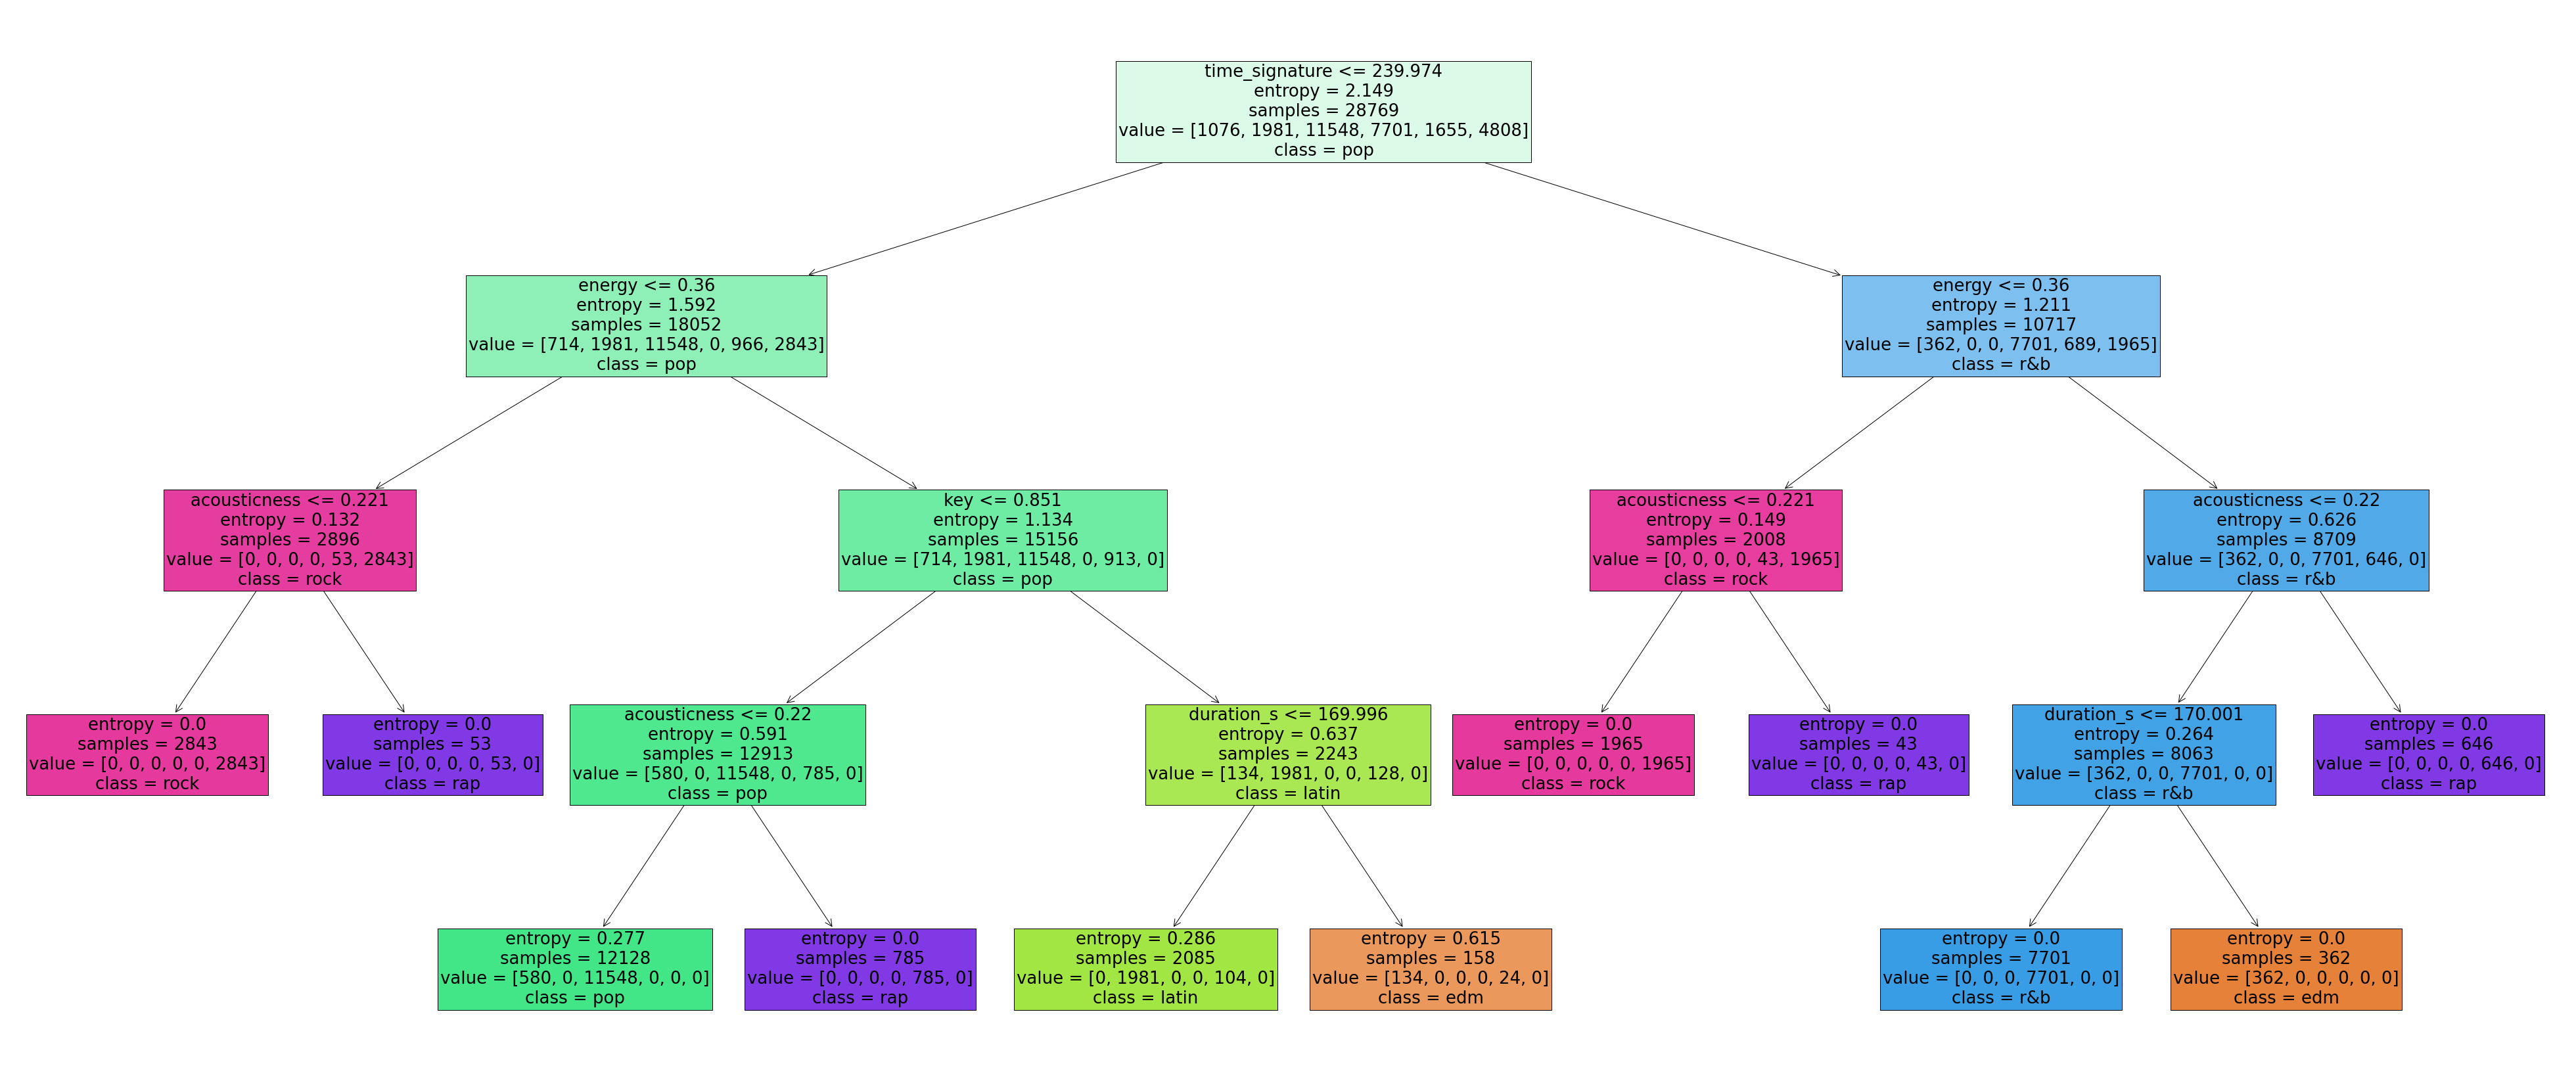

In [19]:
dtree1_train_fig = plt.figure(figsize=(70,30))
dtree1_train_plot = tree.plot_tree(dtree1, 
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True,
                  fontsize=26)

In [20]:
dtree1.feature_importances_

array([0.31847206, 0.14081369, 0.        , 0.        , 0.        ,
       0.14316904, 0.        , 0.        , 0.        , 0.        ,
       0.04961684, 0.34792837, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

#### 4.6.1.2 Make predictions using the model on both train and test splits<a id='4.6.1.2_Make_predictions_using_the_model_on_both_train_and_test_splits'></a>

In [21]:
dtree1_train_pred = dtree1.predict(X_train)

dtree1_test_pred = dtree1.predict(X_test)

In [22]:
dtree1_train_pred = pd.Series(dtree1_train_pred)

dtree1

DecisionTreeClassifier(criterion='entropy', max_depth=4)

#### 4.6.1.3 Assess model performance<a id='4.6.1.3_Assess_model_performance'></a>

##### Training Set

In [23]:
print(metrics.classification_report(y_train, dtree1_train_pred,labels=None,target_names=class_names,sample_weight=None, digits=2, output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

         edm       0.95      0.46      0.62      1076
       latin       0.95      1.00      0.97      1981
         pop       0.95      1.00      0.98     11548
         r&b       1.00      1.00      1.00      7701
         rap       1.00      0.92      0.96      1655
        rock       1.00      1.00      1.00      4808

    accuracy                           0.98     28769
   macro avg       0.98      0.90      0.92     28769
weighted avg       0.98      0.98      0.97     28769



##### Test Set

In [24]:
print(metrics.classification_report(y_test, dtree1_test_pred,labels=None,target_names=class_names,sample_weight=None, digits=2, output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

         edm       0.96      0.48      0.64       439
       latin       0.95      1.00      0.97       889
         pop       0.96      1.00      0.98      4912
         r&b       1.00      1.00      1.00      3339
         rap       1.00      0.92      0.96       709
        rock       1.00      1.00      1.00      2042

    accuracy                           0.98     12330
   macro avg       0.98      0.90      0.92     12330
weighted avg       0.98      0.98      0.97     12330



### 4.6.2 Decision Tree with Gini<a id='4.6.2_Decision_Tree_with_Gini'></a>

#### 4.6.2.1 Train the model on the train split<a id='4.6.2.1_Train_the_model_on_the_train_split'></a>

In [25]:
dtree2 = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 4)

dtree2 = dtree2.fit(X_train, y_train)

dtree2_train_text = export_text(dtree2)
print(dtree2_train_text)

|--- feature_11 <= 240.00
|   |--- feature_0 <= 0.36
|   |   |--- feature_5 <= 0.22
|   |   |   |--- class: rock
|   |   |--- feature_5 >  0.22
|   |   |   |--- class: rap
|   |--- feature_0 >  0.36
|   |   |--- feature_1 <= 0.85
|   |   |   |--- feature_5 <= 0.22
|   |   |   |   |--- class: pop
|   |   |   |--- feature_5 >  0.22
|   |   |   |   |--- class: rap
|   |   |--- feature_1 >  0.85
|   |   |   |--- feature_10 <= 170.00
|   |   |   |   |--- class: latin
|   |   |   |--- feature_10 >  170.00
|   |   |   |   |--- class: edm
|--- feature_11 >  240.00
|   |--- feature_0 <= 0.36
|   |   |--- feature_5 <= 0.22
|   |   |   |--- class: rock
|   |   |--- feature_5 >  0.22
|   |   |   |--- class: rap
|   |--- feature_0 >  0.36
|   |   |--- feature_5 <= 0.22
|   |   |   |--- feature_10 <= 170.00
|   |   |   |   |--- class: r&b
|   |   |   |--- feature_10 >  170.00
|   |   |   |   |--- class: edm
|   |   |--- feature_5 >  0.22
|   |   |   |--- class: rap



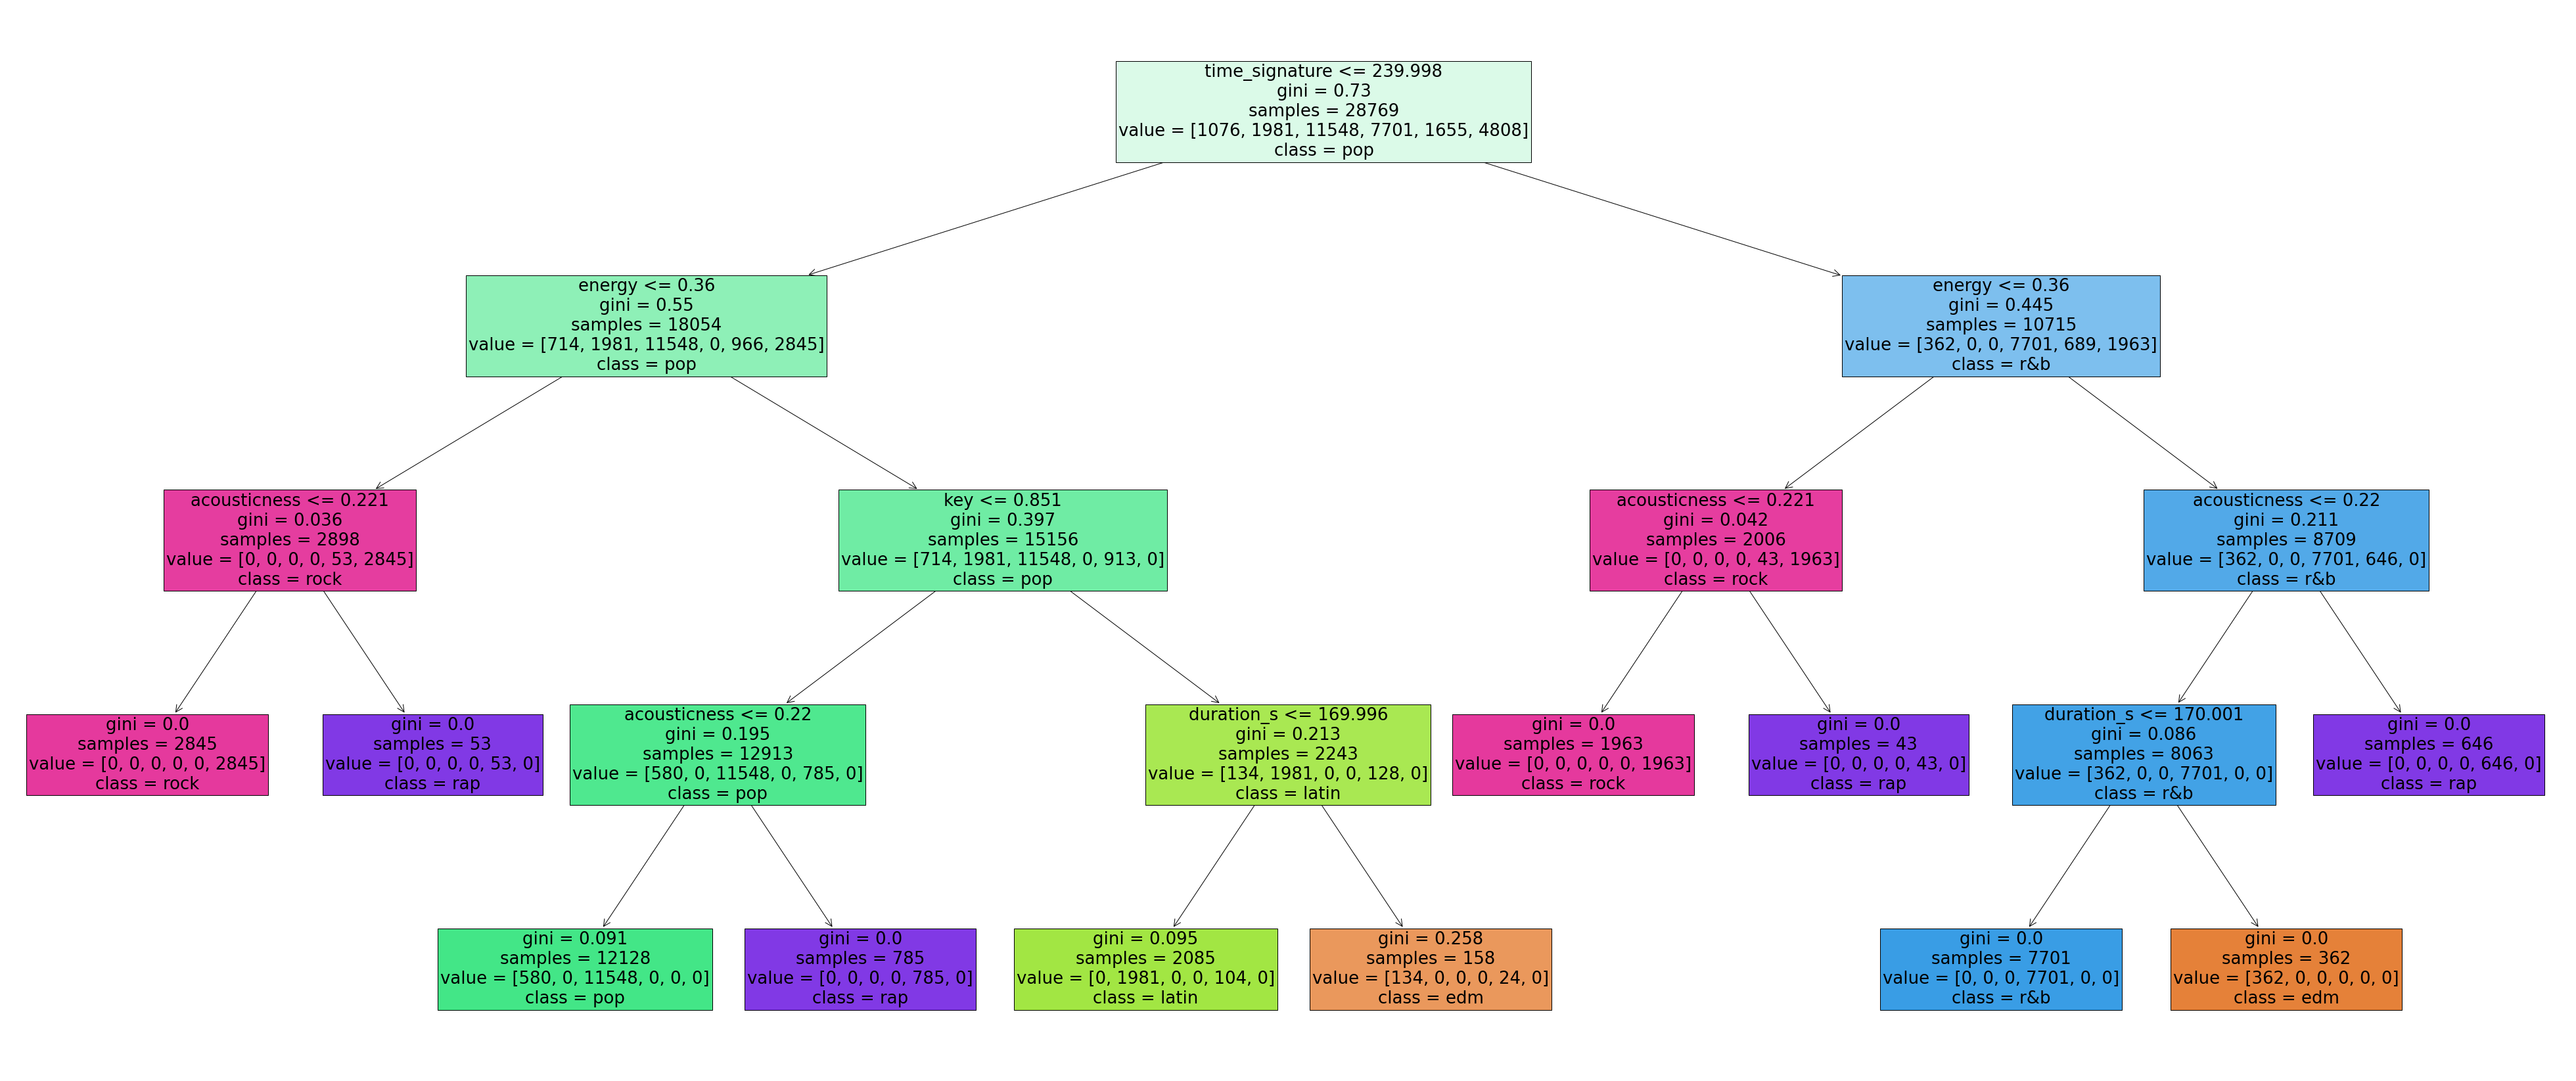

In [26]:
dtree2_train_fig = plt.figure(figsize=(70,30))
dtree2_train_plot = tree.plot_tree(dtree2, 
                   feature_names=feature_names,  
                   class_names=class_names,
                   filled=True,
                  fontsize=26)

In [27]:
dtree2.feature_importances_

array([0.33844662, 0.15363357, 0.        , 0.        , 0.        ,
       0.13943809, 0.        , 0.        , 0.        , 0.        ,
       0.04738235, 0.32109938, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

#### 4.6.2.2 Make predictions using the model on both train and test splits<a id='4.6.2.2_Make_predictions_using_the_model_on_both_train_and_test_splits'></a>
        

In [28]:
dtree2_train_pred = dtree2.predict(X_train)

dtree2_test_pred = dtree2.predict(X_test)

dtree2_train_pred = pd.Series(dtree2_train_pred)

dtree2

DecisionTreeClassifier(max_depth=4)

#### 4.6.2.3 Assess model performance<a id='4.6.2.3_Assess_model_performance'></a>

##### Training Set

In [29]:
print(metrics.classification_report(y_train, dtree2_train_pred,labels=None,target_names=class_names,sample_weight=None, digits=2, output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

         edm       0.95      0.46      0.62      1076
       latin       0.95      1.00      0.97      1981
         pop       0.95      1.00      0.98     11548
         r&b       1.00      1.00      1.00      7701
         rap       1.00      0.92      0.96      1655
        rock       1.00      1.00      1.00      4808

    accuracy                           0.98     28769
   macro avg       0.98      0.90      0.92     28769
weighted avg       0.98      0.98      0.97     28769



##### Test Set

In [30]:
print(metrics.classification_report(y_train, dtree2_train_pred,labels=None,target_names=class_names,sample_weight=None, digits=2, output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

         edm       0.95      0.46      0.62      1076
       latin       0.95      1.00      0.97      1981
         pop       0.95      1.00      0.98     11548
         r&b       1.00      1.00      1.00      7701
         rap       1.00      0.92      0.96      1655
        rock       1.00      1.00      1.00      4808

    accuracy                           0.98     28769
   macro avg       0.98      0.90      0.92     28769
weighted avg       0.98      0.98      0.97     28769



## 4.7 Model Selection<a id='4.7_Model_Selection'></a>

#### Decision Tree with Entropy
The data behaved as expected and performed quite well under the decision tree models.  Since the sizes of the classes varied significantly in size, it appears that running the decision tree with entropy fared slightly better with EDM and .01 increase in precision for pop.  However, the accuracy of the overall model was not affected by the choice of entropy or gini. 

We ran the decision tree against 17 separate features but only 5 features showed any importance with the predictions: time signature, energy, key, acousticness, and duration.

### 4.7.3 Conclusion<a id='4.7.3_Conclusion'></a>

The decision tree model was clearly the right choice for the model as the first selection of criteria produced an accuracy rate of 98%. Since the purpose of this analysis was to help the artist and other interested parties identify a genre, the visual graph of the tree makes a clear and easy way to explain the reccomendations from the model to those without a background in machine learning or statistical models.  